<a href="https://colab.research.google.com/github/Baldros/Prithvi_WxC-ModelExemples-/blob/main/PrithviWxC(Constru%C3%A7%C3%A3oAtmosfera).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Apresentação:

O objetivo desse código é estudar sobre o modelo **Prithvi WxC**, uma iniciativa da **NASA** em parceria com a **IBM _Research_** visando gerar um modelo de _deep learning_ **fundacional** voltado para tarefas meteorológicas relacionadas com tempo e clima.

## Material Base:

* Artigo do modelo: https://arxiv.org/pdf/2409.13598
* Documentação do MERRA-2: https://doi.org/10.1175/JCLI-D-16-0758.1

## Arquitetura Esquematizada:
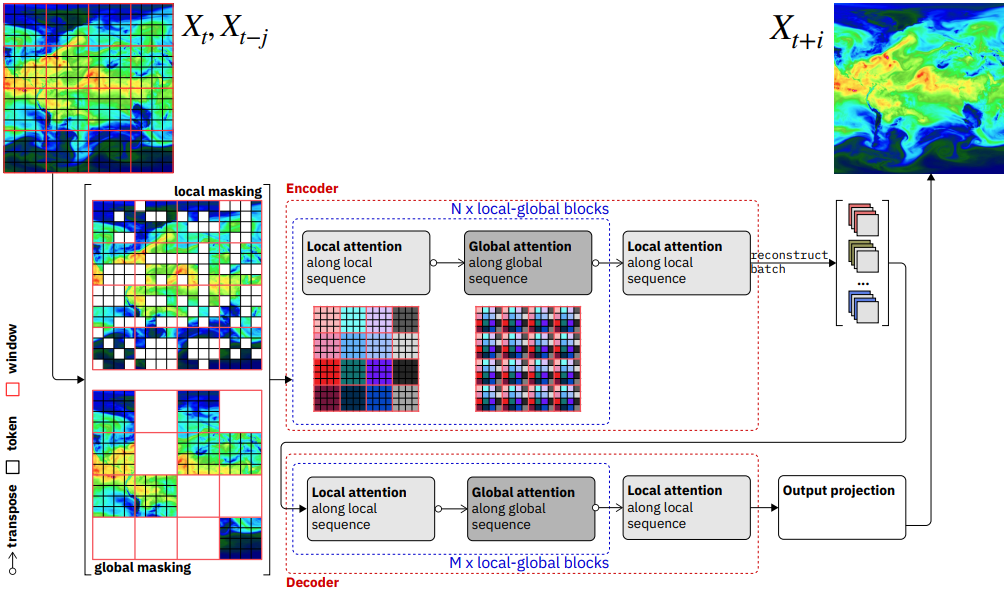

In [1]:
# Instalando dependências necessárias
!pip install --upgrade huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.4/436.4 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: huggingface_hub
    Found existing installation: huggingface-hub 0.24.7
    Uninstalling huggingface-hub-0.24.7:
      Successfully uninstalled huggingface-hub-0.24.7


In [2]:
!git clone https://github.com/NASA-IMPACT/Prithvi-WxC.git

Cloning into 'Prithvi-WxC'...
remote: Enumerating objects: 229, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 229 (delta 37), reused 26 (delta 13), pack-reused 151 (from 1)
Receiving objects: 100% (229/229), 426.13 KiB | 3.41 MiB/s, done.
Resolving deltas: 100% (104/104), done.


In [3]:
# Bibliotecas Utilizadas:
import random
from pathlib import Path

# Bibliotecas de suporte:
import os
import shutil
import numpy as np
from time import time
from matplotlib import pyplot as plt

# Bibliotecas de Deep Learning:
import torch
from huggingface_hub import hf_hub_download, snapshot_download

In [4]:
# Extraindo Pasta do Modelo:
try:
  shutil.move('Prithvi-WxC/PrithviWxC', '.')
  shutil.rmtree('Prithvi-WxC') # Apagando pasta sobressalente
except:
  pass

# Configurando estados do torch:

Por vezes, no contexto de _deep learning_, é comum configurar os estados do torch, especialmente quando se deseja garantir a reprodutibilidade dos experimentos e otimizar o uso de hardware. Algumas considerações:

* **Reprodutibilidade:** Definir as sementes é importante para comparar resultados em experimentos.
* **Otimização:** Configurações como torch.backends.cudnn.benchmark e torch.backends.cudnn.deterministic ajudam a balancear desempenho e consistência, dependendo do objetivo do projeto.
* **Dispositivos:** Verificar se uma GPU está disponível e configurar automaticamente é uma prática comum para garantir que o modelo seja executado da maneira mais eficiente possível.

Esse código é especialmente útil para garantir um treinamento controlado e eficiente, adequado tanto para a validação de modelos quanto para a produção, onde consistência e performance são essenciais.

In [5]:
# Habilitanto onednn Fusion:
torch.jit.enable_onednn_fusion(True)

* `torch.jit.enable_onednn_fusion(True)`: Habilita a fusão de operações para otimizar o desempenho no backend OneDNN (anteriormente conhecido como MKL-DNN). Isso geralmente ajuda a acelerar o desempenho em operações comuns, especialmente para a inferência.

In [6]:
# Avaliando Possibin:
if torch.cuda.is_available():
    print(f"Device Utilizado: {torch.cuda.get_device_name()}")
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

* `torch.backends.cudnn.benchmark = True`: Configura o CUDNN para procurar a melhor configuração para operações específicas, com base nos tamanhos de entrada fornecidos. Isso é útil quando se trabalha com entradas de tamanhos variados, pois melhora o desempenho.

* `torch.backends.cudnn.deterministic = True`: Garante que a execução seja determinística, ou seja, que os resultados sejam reprodutíveis. No entanto, isso pode ter um custo de desempenho, pois o benchmark pode não encontrar a implementação mais rápida.

In [7]:
# Definindo as sementes dos geradores de números aleatórios (RNG):
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.manual_seed(42)
np.random.seed(42)

In [8]:
# Setando device:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Device Utilizado: {device}")
else:
    device = torch.device("cpu")
    print(f"Device Utilizado: {device}")

Device Utilizado: cpu


É importante mencionar que esse modelo tem aproximadamente 2.3 bilhões de parâmetros, o que se faz interessante a capacidade de utilização de GPU.

# Dataloader:

O **MERRA-2** é uma estrutura multidimensional de dados, o que significa que primeiro precisamos definir o primeiro conjunto de variáveis, um conjunto fixo de variáveis que o modelo usará como entrada.

## Variáveis e tempos:
Com o ambiente pronto para funcionar, agora precisamos configurar a tarefa. O modelo principal espera um conjunto fixo de variáveis do dataset **MERRA-2**, que estão prescritas abaixo. As variáveis são compostas por:
* variáveis de superfície;
* variáveis estáticas de superfície; e
* variáveis em vários níveis verticais dentro da atmosfera.

Para mais detalhes,
* https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/

O dataset **MERRA-2** inclui dados nas longitudes de $360°$. Isso representa dados duplicados, então definimos uma variável de preenchimento (_padding_) para removê-los.

A entrada para o modelo principal consiste nessas variáveis em dois momentos diferentes. A diferença de tempo em horas entre essas amostras é passada para o modelo e configurada na variável `input_time`.

In [9]:
# Variáveis de superfície:
surface_vars = [
    "EFLUX",
    "GWETROOT",
    "HFLUX",
    "LAI",
    "LWGAB",
    "LWGEM",
    "LWTUP",
    "PS",
    "QV2M",
    "SLP",
    "SWGNT",
    "SWTNT",
    "T2M",
    "TQI",
    "TQL",
    "TQV",
    "TS",
    "U10M",
    "V10M",
    "Z0M",
]

# Variáveis estáticas de superfície
static_surface_vars = ["FRACI", "FRLAND", "FROCEAN", "PHIS"]

# Variáveis verticais:
vertical_vars = ["CLOUD", "H", "OMEGA", "PL", "QI", "QL", "QV", "T", "U", "V"]

# Níveis:
levels = [
    34.0,
    39.0,
    41.0,
    43.0,
    44.0,
    45.0,
    48.0,
    51.0,
    53.0,
    56.0,
    63.0,
    68.0,
    71.0,
    72.0,
]

# Dicionário para remover duplicatas:
padding = {"level": [0, 0], "lat": [0, -1], "lon": [0, 0]}

## Tarefa:

A tarefa do modelo é prever o conjunto fixo de variáveis em um tempo-alvo, dado os dados de entrada, ou seja, reconstruir o comportamento atmosférico em um momento específico.

In [10]:
# Definido Tarefas:
lead_times = [6]
input_times = [-6]

Esta variável pode ser alterada para alterar a tarefa.

## Arquivo de dados:

Os dados do **MERRA-2** estão disponíveis de 1980 até o presente, com **resolução temporal** de 3 horas (Os dados são atualizados de 3 em 3 horas). O `dataloader` que fornecemos espera que os dados de superfície e os dados verticais sejam salvos em arquivos separados e, quando fornecidos com os diretórios, ele buscará os dados relevantes que se enquadram no intervalo de tempo fornecido.

In [11]:
# Range de Tempo:
time_range = ("2020-01-01T00:00:00", "2020-01-01T23:59:59")

# Dados de Superfície:
surf_dir = Path("./merra-2")
snapshot_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    allow_patterns="merra-2/MERRA2_sfc_2020010[1].nc",
    local_dir=".",
)

# Dados da variável Vertical:
vert_dir = Path("./merra-2")
snapshot_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    allow_patterns="merra-2/MERRA_pres_2020010[1].nc",
    local_dir=".",
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:90: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

MERRA2_sfc_20200101.nc:   0%|          | 0.00/102M [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

MERRA_pres_20200101.nc:   0%|          | 0.00/337M [00:00<?, ?B/s]

'/content'

## Verificando Dados:

Esses dados são do MERRA-2, e serão os dados que vamos utilizar para ajustar o modelo. São dados no formato **netCDF4**, então é bom ter um certa experiência em lidar com esse tipo de dado. Não parece ser nada muito complexo, mas precisaria de um código próprio só para explorar esses dados.

In [12]:
!pip install xarray netCDF4 h5netcdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 73.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 42.6 MB/s eta 0:00:00


In [13]:
# Biblioteca para lidar com netCDF:
import xarray as xr

In [14]:
# Abrir o arquivo NetCDF
datasetxr1 = xr.open_dataset("/content/merra-2/MERRA2_sfc_20200101.nc")

# Mostrar uma visão geral do dataset
print(datasetxr1)

<xarray.Dataset> Size: 143MB
Dimensions:   (time: 8, lat: 361, lon: 576)
Coordinates:
  * lon       (lon) float64 5kB -180.0 -179.4 -178.8 ... 178.1 178.8 179.4
  * lat       (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * time      (time) datetime64[ns] 64B 2020-01-01 ... 2020-01-01T21:00:00
Data variables: (12/25)
    U10M      (time, lat, lon) float32 7MB ...
    V10M      (time, lat, lon) float32 7MB ...
    T2M       (time, lat, lon) float32 7MB ...
    QV2M      (time, lat, lon) float32 7MB ...
    PS        (time, lat, lon) float32 7MB ...
    SLP       (time, lat, lon) float32 7MB ...
    ...        ...
    SWGNT     (time, lat, lon) float32 7MB ...
    SWTNT     (time, lat, lon) float32 7MB ...
    PHIS      (lat, lon) float32 832kB ...
    FRLAND    (lat, lon) float32 832kB ...
    FROCEAN   (lat, lon) float32 832kB ...
    FRACI     (lat, lon) float32 832kB ...
Attributes: (12/30)
    History:                           Original file generated: Mon Jan 1

In [15]:
# Abrir o arquivo NetCDF
datasetxr2 = xr.open_dataset("/content/merra-2/MERRA_pres_20200101.nc")

# Mostrar uma visão geral do dataset
print(datasetxr2)

<xarray.Dataset> Size: 932MB
Dimensions:  (time: 8, lev: 14, lat: 361, lon: 576)
Coordinates:
  * lon      (lon) float64 5kB -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat      (lat) float64 3kB -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * lev      (lev) float64 112B 72.0 71.0 68.0 63.0 56.0 ... 43.0 41.0 39.0 34.0
  * time     (time) datetime64[ns] 64B 2020-01-01 ... 2020-01-01T21:00:00
Data variables:
    U        (time, lev, lat, lon) float32 93MB ...
    V        (time, lev, lat, lon) float32 93MB ...
    T        (time, lev, lat, lon) float32 93MB ...
    QV       (time, lev, lat, lon) float32 93MB ...
    OMEGA    (time, lev, lat, lon) float32 93MB ...
    PL       (time, lev, lat, lon) float32 93MB ...
    H        (time, lev, lat, lon) float32 93MB ...
    CLOUD    (time, lev, lat, lon) float32 93MB ...
    QI       (time, lev, lat, lon) float32 93MB ...
    QL       (time, lev, lat, lon) float32 93MB ...
Attributes: (12/30)
    History:                       

# Estruturação de Elementos Meteorológicos:

Depois de definir as variáveis de entrada, é necessário incluir os dados climáticos. A climatologia fornece uma referência que representa o comportamento típico ou médio do clima para um determinado período e local. A ideia aqui é treinar o modelo para aprender **a partir de perturbações da climatologia**.



## Climatologia
O modelo **PrithviWxC** foi treinado para calcular a saída produzindo uma perturbação na climatologia no tempo-alvo. Esse modo de operação é configurado por meio da opção `residual=climate`.

Isso foi escolhido porque a climatologia geralmente é um forte ponto de partida para previsões de longo prazo. Ao usar a opção `residual=climate`, é necessário fornecer então ao `dataloader` o caminho dos dados de climatologia.

In [16]:
# Dados de climatologia de Superfície
surf_clim_dir = Path("./climatology")
snapshot_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    allow_patterns="climatology/climate_surface_doy00[1]*.nc",
    local_dir=".",
)

# Dados de climatólogia de
vert_clim_dir = Path("./climatology")
snapshot_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    allow_patterns="climatology/climate_vertical_doy00[1]*.nc",
    local_dir=".",
)

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

climate_surface_doy001_hour03.nc:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

climate_surface_doy001_hour09.nc:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

climate_surface_doy001_hour00.nc:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

climate_surface_doy001_hour21.nc:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

climate_surface_doy001_hour18.nc:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

climate_surface_doy001_hour12.nc:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

climate_surface_doy001_hour06.nc:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

climate_surface_doy001_hour15.nc:   0%|          | 0.00/20.8M [00:00<?, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

climate_vertical_doy001_hour00.nc:   0%|          | 0.00/116M [00:00<?, ?B/s]

climate_vertical_doy001_hour06.nc:   0%|          | 0.00/116M [00:00<?, ?B/s]

climate_vertical_doy001_hour03.nc:   0%|          | 0.00/116M [00:00<?, ?B/s]

climate_vertical_doy001_hour18.nc:   0%|          | 0.00/116M [00:00<?, ?B/s]

climate_vertical_doy001_hour15.nc:   0%|          | 0.00/116M [00:00<?, ?B/s]

climate_vertical_doy001_hour09.nc:   0%|          | 0.00/116M [00:00<?, ?B/s]

climate_vertical_doy001_hour12.nc:   0%|          | 0.00/116M [00:00<?, ?B/s]

climate_vertical_doy001_hour21.nc:   0%|          | 0.00/116M [00:00<?, ?B/s]

'/content'

# Posicional Encoding:

Essa etapa é fundamental dentro do contexto de um modelo _based-Transformers_, porque é justamente ela que define a **dependência sequencial** dos dados. Diferente de modelos como **Redes Neurais Recorrentes (RNN)**, a arquitetura Transformer não possui estrutura intrínseca para capturar a sequência ou a posição dos dados de entrada.


De forma resumida, é graças a esse processo de codificação posicioanal que esse modelo serve para lidar com sequências. O que possibilitou a construção dos **modelos de linguagem (LLM)** e a extensão para lidar com séries temporias.

In [17]:
# Definindo Estratégia de Encoding Posicional:
positional_encoding = "fourier"

Existem algumas estratégias para elaborar esse encoding posicional, aqui vamos escolher a tradicional codificação _sinusoidal_ ou de _fourier_. $Senos$ e $Cossenos$ são funções periódicas, o que deixa fácil o mapeamento posicional.

# Iniciando Dataset:

Definido toda a configuração para a construção do modelo, e tendo os dados. Podemos iniciar as instância necessárias para a construção da inferência do modelo.

In [18]:
# Classe do modelo:
from PrithviWxC.dataloaders.merra2 import Merra2Dataset

In [19]:
# Instanciando dataset:
dataset = Merra2Dataset(
    time_range=time_range,
    lead_times=lead_times,
    input_times=input_times,
    data_path_surface=surf_dir,
    data_path_vertical=vert_dir,
    climatology_path_surface=surf_clim_dir,
    climatology_path_vertical=vert_clim_dir,
    surface_vars=surface_vars,
    static_surface_vars=static_surface_vars,
    vertical_vars=vertical_vars,
    levels=levels,
    positional_encoding=positional_encoding,
)
assert len(dataset) > 0, "Não parece haver nenhum dado válido."

# PrithviWxC, O Modelo:

Feito toda essa configuração do ambiente vamos intancianr o modelo. Toda a estruturação da classe do modelo já está pronta, de modo que aqui só vamos instanciálo, como uma biblioteca qualquer, como se faz com qualquer outro modelo de Machine Learning como do sklearn, por exemplo.

Dito isso, é válido dizer que podemos ter acesso a construção do modelo toda do zero no [github da NASA-IMPACT](https://github.com/NASA-IMPACT/Prithvi-WxC/blob/main/PrithviWxC/model.py), só com pytorch. É uma experiência interessante, ainda que tentar, entender a implementação desse modelo. (A implementação do modelo não será feita aqui se não o código ficaria imenso).

## Escaladores:

Dito isso, o modelo toma como parâmetros estáticos os valores de média e variância das variáveis ​​de entrada e os valores de variância da diferença alvo, ou seja, a variância entre a climatologia e as variáveis ​​instantâneas. Fornecemos arquivos de dados contendo esses valores e aqui carregamos esses dados.



In [20]:
from PrithviWxC.dataloaders.merra2 import (
    input_scalers,
    output_scalers,
    static_input_scalers,
)

In [21]:
surf_in_scal_path = Path("./climatology/musigma_surface.nc")
hf_hub_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    filename=f"climatology/{surf_in_scal_path.name}",
    local_dir=".",
)

vert_in_scal_path = Path("./climatology/musigma_vertical.nc")
hf_hub_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    filename=f"climatology/{vert_in_scal_path.name}",
    local_dir=".",
)

surf_out_scal_path = Path("./climatology/anomaly_variance_surface.nc")
hf_hub_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    filename=f"climatology/{surf_out_scal_path.name}",
    local_dir=".",
)

vert_out_scal_path = Path("./climatology/anomaly_variance_vertical.nc")
hf_hub_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    filename=f"climatology/{vert_out_scal_path.name}",
    local_dir=".",
)

in_mu, in_sig = input_scalers(
    surface_vars,
    vertical_vars,
    levels,
    surf_in_scal_path,
    vert_in_scal_path,
)

output_sig = output_scalers(
    surface_vars,
    vertical_vars,
    levels,
    surf_out_scal_path,
    vert_out_scal_path,
)

static_mu, static_sig = static_input_scalers(
    surf_in_scal_path,
    static_surface_vars,
)

musigma_surface.nc:   0%|          | 0.00/24.7k [00:00<?, ?B/s]

musigma_vertical.nc:   0%|          | 0.00/25.0k [00:00<?, ?B/s]

anomaly_variance_surface.nc:   0%|          | 0.00/11.5k [00:00<?, ?B/s]

anomaly_variance_vertical.nc:   0%|          | 0.00/18.6k [00:00<?, ?B/s]

## Tarefa e configurações adicionais

Como mencionado anteriormente, a tarefa principal do modelo **PrithviWxC** envolveu **prever a variável desejada em um _lead time_ específico**. Isso foi alcançado calculando a diferença (delta) em relação à média climatológica naquele momento. Esse modo de operação é ativado usando a _flag residual_ (configuração do modelo que define como o ele deve lidar com a previsão em termos de diferença em relação a um valor de referência.). Embora o modelo inclua opções residuais adicionais, os pesos do modelo principal não foram treinados utilizando esses modos.

Além disso, para o treinamento e avaliação, é possível mascarar _tokens_ no modelo. O mascaramento ocorre após a tokenização, antes das camadas do _encoder_. O modelo utiliza atenção multi-eixo, com os dados divididos em uma hierarquia de _patches_ locais e globais. Consequentemente, o mascaramento pode ser configurado para mascarar pequenos patches locais ou patches globais maiores. Essa configuração é realizada por meio da flag `masking_mode`. É possível definir `masking_mode=both`. Isso não mistura os modos, mas permite que ambos os modos sejam utilizados e alternados, principalmente para fins de treinamento. Para esta demonstração, ajustaremos a taxa de mascaramento para mostrar as capacidades de reconstrução do modelo.

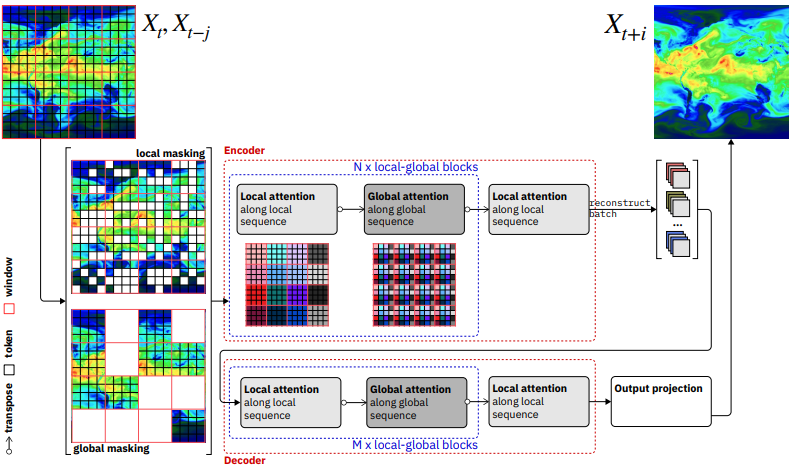

Por fim, podemos configurar o deslocamento (_shifting_). Utilizado principalmente no decodificador, isso permite o deslocamento alternado das janelas de atenção, semelhante ao modelo SWIN. Essa opção requer um número par de blocos de decodificação e é incompatível com o codificador quando o mascaramento também é empregado.








In [22]:
residual = "climate"
masking_mode = "local"
decoder_shifting = True
masking_ratio = 0.99

## Inicialização do modelo

Agora temos todos os elementos para construir o modelo. Se você estiver usando os pesos pré-treinados, vários dos hiperparâmetros do modelo já estão predeterminados e incluídos abaixo. Com essa configuração, o modelo terá aproximadamente 2,3 bilhões de parâmetros. Portanto, se você quiser treinar o modelo completamente não congelado, provavelmente precisará usar uma abordagem de distribuição do modelo, como o paralelismo de dados totalmente compartilhado (FSDP). Para reduzir ainda mais o uso de memória quando os gradientes são necessários, existem duas variáveis — `checkpoint_encoder` e `checkpoint_decoder` — que permitem o checkpoint de ativações em camadas específicas do transformer.

In [23]:
# Importando Classe do Modelo:
from PrithviWxC.model import PrithviWxC
import yaml

In [24]:
# Baixando configuração yaml:
hf_hub_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    filename=f"config.yaml",
    local_dir=".",
)

# Definições dos hiperparâmetros :
with open('./config.yaml', 'r') as f:
    config = yaml.safe_load(f)

config.yaml:   0%|          | 0.00/428 [00:00<?, ?B/s]

In [25]:
# Instanciando Modelo:
model = PrithviWxC(
    in_channels=config['params']['in_channels'],
    input_size_time=config['params']['input_size_time'],
    in_channels_static=config['params']['in_channels_static'],
    input_scalers_mu=in_mu,
    input_scalers_sigma=in_sig,
    input_scalers_epsilon=config['params']['input_scalers_epsilon'],
    static_input_scalers_mu=static_mu,
    static_input_scalers_sigma=static_sig,
    static_input_scalers_epsilon=config['params']['static_input_scalers_epsilon'],
    output_scalers=output_sig**0.5,
    n_lats_px=config['params']['n_lats_px'],
    n_lons_px=config['params']['n_lons_px'],
    patch_size_px=config['params']['patch_size_px'],
    mask_unit_size_px=config['params']['mask_unit_size_px'],
    mask_ratio_inputs=masking_ratio,
    embed_dim=config['params']['embed_dim'],
    n_blocks_encoder=config['params']['n_blocks_encoder'],
    n_blocks_decoder=config['params']['n_blocks_decoder'],
    mlp_multiplier=config['params']['mlp_multiplier'],
    n_heads=config['params']['n_heads'],
    dropout=config['params']['dropout'],
    drop_path=config['params']['drop_path'],
    parameter_dropout=config['params']['parameter_dropout'],
    residual=residual,
    masking_mode=masking_mode,
    decoder_shifting=decoder_shifting,
    positional_encoding=positional_encoding,
    checkpoint_encoder=[],
    checkpoint_decoder=[],
)

## Carregando Pesos:

Treinar esses modelos tem um custo computacional e energético muito grande. Modelo pré-treinados, como o nome já diz, já foram pré-treinados, sendo assim, podemos só baixar os pesos já ajustados e utilizar. Essa é uma das vantagens desses modelos pré-treinados.

Todavia, nada nos empede de treinarmos mais ainda esses modelos, especificando-os para nossas demandas, diga-se de passagem, é dai de onde vem o termo _fine-tuning_. _fine-tuning_ nada mais é do que treinar esses modelos já pré-treinados.


In [26]:
# Baixando checkpoint (Pesos do Modelo):
weights_path = Path("./weights/prithvi.wxc.2300m.v1.pt")
hf_hub_download(
    repo_id="Prithvi-WxC/prithvi.wxc.2300m.v1",
    filename=weights_path.name,
    local_dir="./weights",
)

state_dict = torch.load(weights_path, weights_only=False)
if "model_state" in state_dict:
    state_dict = state_dict["model_state"]
model.load_state_dict(state_dict, strict=True)

if (hasattr(model, "device") and model.device != device) or not hasattr(
    model, "device"
):
    model = model.to(device)

prithvi.wxc.2300m.v1.pt:   0%|          | 0.00/28.4G [00:00<?, ?B/s]

# Inferência:

Agora estamos prontos para realizar a inferência no modelo. Os dados retornados pela classe do `dataset` precisam de pré-processamento adicional; portanto, após obter os dados do `dataset`, nós os processamos usando a função `preproc`. Esses dados processados são então transferidos para o dispositivo (GPU ou CPU). Para recuperar o mascaramento, podemos salvar o estado do RNG (gerador de números aleatórios) do PyTorch e usá-lo posteriormente. Finalmente, executamos o modelo em modo de avaliação sem gerar o gráfico de gradientes.

In [27]:
# Importando Função:
from PrithviWxC.dataloaders.merra2 import preproc

In [28]:
data = next(iter(dataset))
batch = preproc([data], padding)

for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.to(device)
# Feedfoward:
rng_state_1 = torch.get_rng_state()
with torch.no_grad():
    model.eval()
    out = model(batch)

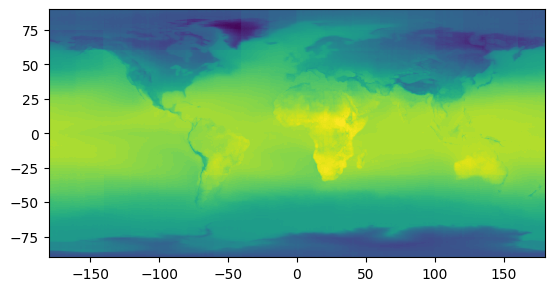

In [29]:
# Visualização do Resultado:
t2m = out[0, 12].cpu().numpy()

lat = np.linspace(-90, 90, out.shape[-2])
lon = np.linspace(-180, 180, out.shape[-1])
X, Y = np.meshgrid(lon, lat)

plt.contourf(X, Y, t2m, 100)
plt.gca().set_aspect("equal")
plt.show()